Import Libraries

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

Data collection and analysis

In [4]:
trainingSet = pd.read_csv('Train.csv')

In [5]:
trainingSet.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
trainingSet.shape

(8523, 12)

In [7]:
trainingSet.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
trainingSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical Features:-
Item_Identifier
Item_Fat_Content
Item_Type
Outlet_Identifier
Outlet_Size
Outlet_Location_Type
Outlet_Type

Handling missing values:-
Mean for numerical
Mode for categorical

In [9]:
trainingSet['Item_Weight'].mean()

12.857645184135976

In [10]:
trainingSet['Item_Weight'].fillna(trainingSet['Item_Weight'].mean(), inplace=True)

In [56]:
modeOutletSize = trainingSet.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [57]:
print(modeOutletSize)

Outlet_Type                                 0      1       2       3
Outlet_Size  [[Small, Small, Medium, Medium]]  Small  Medium  Medium


In [58]:
missing = trainingSet['Outlet_Size'].isnull()
print(missing)

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [99]:
trainingSet.loc[missing, 'Outlet_Size'] = trainingSet.loc[missing, 'Outlet_Type'].apply(lambda x: modeOutletSize[x])

In [100]:
trainingSet.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

EDA

In [101]:
trainingSet.describe()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,779.714889,12.857645,0.366420,0.066132,7.226681,140.992782,4.722281,1997.831867,1.112871,1.201220,2181.288914
std,449.222377,4.226124,0.509551,0.051598,4.209990,62.275067,2.837201,8.371760,0.812757,0.796459,1706.499616
min,0.000000,4.555000,0.000000,0.000000,0.000000,31.290000,0.000000,1985.000000,0.000000,0.000000,33.290000
25%,395.500000,9.310000,0.000000,0.026989,4.000000,93.826500,2.000000,1987.000000,0.000000,1.000000,834.247400
50%,783.000000,12.857645,0.000000,0.053931,6.000000,143.012800,5.000000,1999.000000,1.000000,1.000000,1794.331000
75%,1167.000000,16.000000,1.000000,0.094585,10.000000,185.643700,7.000000,2004.000000,2.000000,1.000000,3101.296400
max,1558.000000,21.350000,2.000000,0.328391,15.000000,266.888400,9.000000,2009.000000,2.000000,3.000000,13086.964800


In [102]:
sns.set()

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

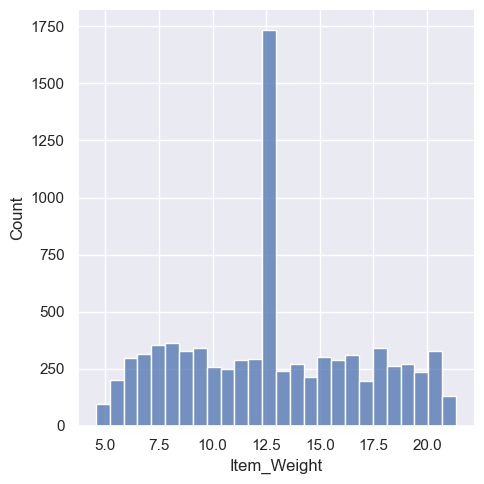

In [103]:
plt.figure(figsize=(6,6))
sns.displot(trainingSet['Item_Weight'])
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

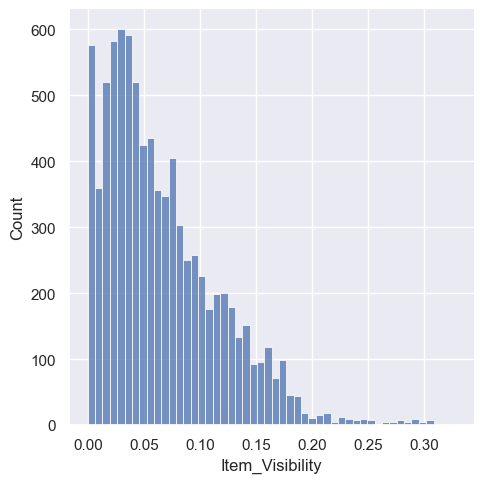

In [104]:
plt.figure(figsize=(6,6))
sns.displot(trainingSet['Item_Visibility'])
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

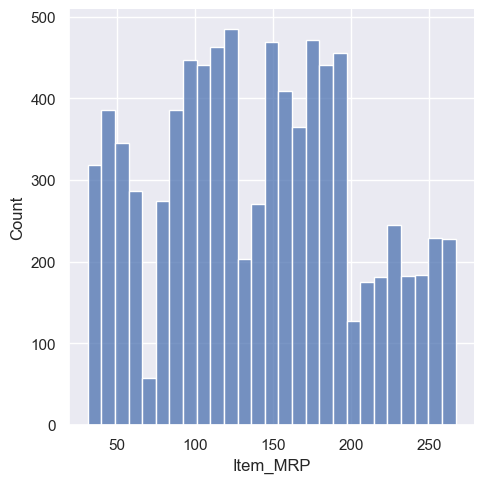

In [105]:
plt.figure(figsize=(6,6))
sns.displot(trainingSet['Item_MRP'])
plt.show()

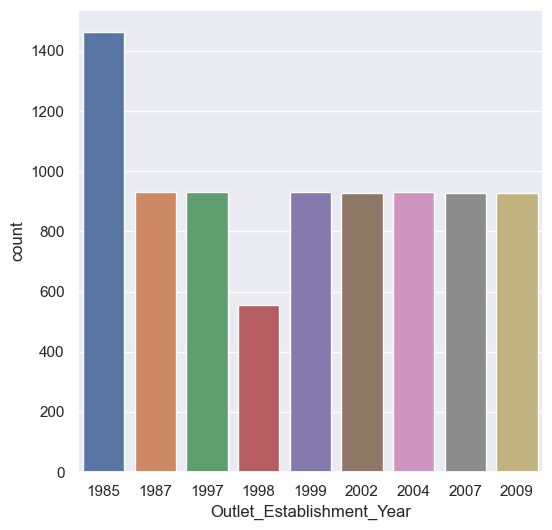

In [106]:
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=trainingSet)
plt.show()

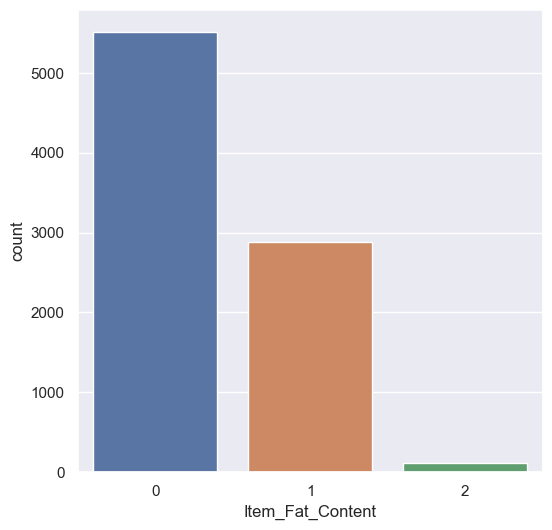

In [107]:
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=trainingSet)
plt.show()

In [108]:
trainingSet['Item_Fat_Content'].value_counts()

Item_Fat_Content
0    5517
1    2889
2     117
Name: count, dtype: int64

In [109]:
trainingSet.replace({'Item_Fat_Content':{'low fat':'Low Fat', 'LF':'Low Fat', 'reg':'regular'}}, inplace=True)

Label Encoding

In [110]:
encoder = LabelEncoder()

In [117]:
trainingSet['Item_Identifier'] = encoder.fit_transform(trainingSet['Item_Identifier'])
trainingSet['Item_Fat_Content'] = encoder.fit_transform(trainingSet['Item_Fat_Content'])
trainingSet['Item_Type'] = encoder.fit_transform(trainingSet['Item_Type'])
trainingSet['Outlet_Identifier'] = encoder.fit_transform(trainingSet['Outlet_Identifier'])
trainingSet['Outlet_Size'] = encoder.fit_transform(trainingSet['Outlet_Size'])
trainingSet['Outlet_Location_Type'] = encoder.fit_transform(trainingSet['Outlet_Location_Type'])
trainingSet['Outlet_Type'] = encoder.fit_transform(trainingSet['Outlet_Type'])

In [118]:
X = trainingSet.drop(columns='Item_Outlet_Sales', axis =1)
y = trainingSet['Item_Outlet_Sales']

print(X)
print(y)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

train test split

In [120]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=2)

Model Training

In [121]:
regressor = XGBRegressor()
regressor.fit(Xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluation

In [131]:
trainingPrediction = regressor.predict(Xtrain)

In [132]:
r2Train = metrics.r2_score(ytrain, trainingPrediction)
print(r2Train)

0.863969452970507


In [133]:
testPrediction = regressor.predict(Xtest)
r2Test = metrics.r2_score(ytest, testPrediction)
print(r2Test)

0.5195950569648478
